In [31]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [32]:
# load data for each cut state
cuts = {}
for cut in ['rough', 'smooth', 'uncut']:
    # load .npy file
    cuts[cut] = np.load(f'{cut}_array.npy')

In [33]:
cuts['smooth'].shape

(5, 10, 3, 112, 121)

In [34]:
# form a new dataset, which is a table
y = []
dataset = []
for k, cut in enumerate(['rough', 'smooth', 'uncut']):
    for i, torque in enumerate([0, 60 ,120, 240, 480]):
        for j, voltage in enumerate(range(10)):
            sample_locs = np.random.choice(range(112), 4, replace=False)
            wave_data = cuts[cut][i, j, 0, sample_locs, :]
            wave_data = wave_data.flatten()
            # concatenate the torque and voltage
            dataset.append(np.concatenate([[k, torque, voltage], wave_data]))

In [35]:
# split into train / val / test in  90 / 10 / 10
dataset = np.array(dataset)
np.random.shuffle(dataset)
train, val, test = np.split(dataset, [int(.9 * len(dataset)), int(.95 * len(dataset))])

# split into X and y
X_train, y_train = train[:, 1:], train[:, 0]
X_val, y_val = val[:, 1:], val[:, 0]
X_test, y_test = test[:, 1:], test[:, 0]

In [52]:
# Convert data to DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Define the hyperparameter grid
param_grid = {
    'max_depth': [2, 3, 5, 7, 8, 10],
    'eta': [0.01, 0.1, 0.2],
    'colsample_bytree': [0.3, 0.7],
    'n_estimators': [2, 10, 50, 100],
    'early_stopping_rounds': [10, 100]
}

# Create an XGBoost model
xgb_model = xgb.XGBClassifier(objective='multi:softprob', num_class=3)

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_log_loss', cv=3)
grid_search.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

# Best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Best trained model
best_model = grid_search.best_estimator_

# Predictions on the validation set
y_val_pred = best_model.predict(X_val)

# Evaluate the model on the validation set
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", accuracy)


Best Hyperparameters: {'colsample_bytree': 0.7, 'early_stopping_rounds': 10, 'eta': 0.1, 'max_depth': 5, 'n_estimators': 10}
Validation Accuracy: 0.5714285714285714


In [54]:
# confusion matrix on test set
from sklearn.metrics import confusion_matrix
y_test_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_test_pred)
print(cm)

[[2 1 1]
 [1 0 2]
 [0 0 1]]


In [95]:
# use T-SNE to visualize the data
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
data_tsne = []
labels_tsne = []
for k, cut in enumerate(['rough', 'smooth', 'uncut']):
    for i, torque in enumerate([0, 60 ,120, 240, 480]):
        for j, voltage in enumerate(range(10)):
            for loc in range(112):
                wave_data = cuts[cut][i, j, 0, loc, :]
                wave_data = wave_data.flatten()
                data_tsne.append(wave_data)
                labels_tsne.append(k)
data_tsne = np.array(data_tsne)
# data_tsne_embedded = tsne.fit_transform(data_tsne)


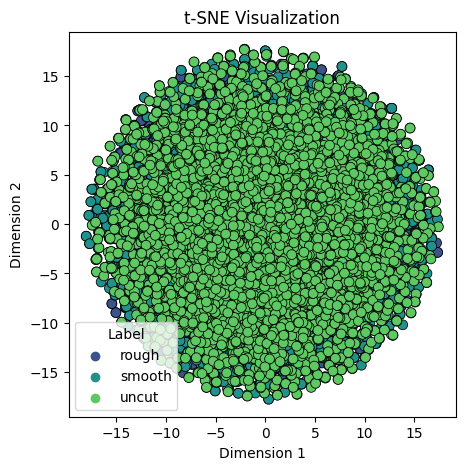

In [67]:
import seaborn as sns
import pandas as pd

# Creating a DataFrame for easy plotting with Seaborn
df = pd.DataFrame({'Dimension 1': data_tsne_embedded[:, 0], 'Dimension 2': data_tsne_embedded[:, 1], 'Label': labels_tsne})

# Plotting with Seaborn
plt.figure(figsize=(5, 5))
sns.scatterplot(x='Dimension 1', y='Dimension 2', hue='Label', data=df, palette='viridis', edgecolor='k', s=50)

plt.title('t-SNE Visualization')
plt.show()

In [99]:
idx = np.arange(data_tsne.shape[0])
np.random.shuffle(idx)
idx.shape

(16800,)

In [100]:
# load and reduce with UMAP
import umap
reducer = umap.UMAP(random_state=42)

data_tsne = data_tsne[idx,:]
labels_tsne = np.array(labels_tsne)[idx]

data_train_tsne = data_tsne[:15000]
labels_train_tsne = labels_tsne[:15000]
embedding = reducer.fit_transform(data_train_tsne, y=labels_train_tsne)


/Users/renatsergazinov/anaconda3/envs/statconsult/lib/python3.7/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [101]:
data_test_tsne = data_tsne[15000:]
embedding = reducer.transform(data_test_tsne)

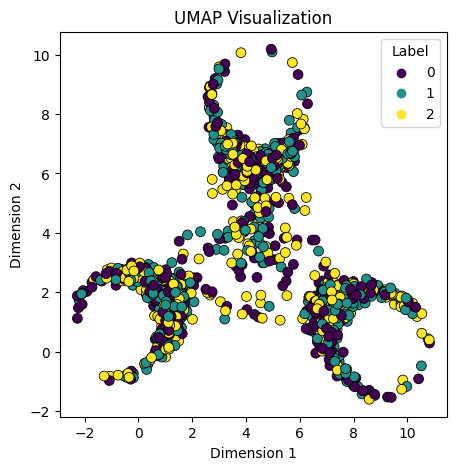

In [102]:
import seaborn as sns
import pandas as pd

# Creating a DataFrame for easy plotting with Seaborn
df = pd.DataFrame({'Dimension 1': embedding[:, 0], 'Dimension 2': embedding[:, 1], 'Label': labels_tsne[15000:]})

# Plotting with Seaborn
plt.figure(figsize=(5, 5))
sns.scatterplot(x='Dimension 1', y='Dimension 2', hue='Label', data=df, palette='viridis', edgecolor='k', s=50)

plt.title('UMAP Visualization')
plt.show()

In [70]:
# load MNIST data
import tensorflow as tf
from tensorflow.keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# reduce with UMAP
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X_train.reshape(60000, 784), y_train)


2023-11-13 22:11:20.785298: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


11490434/11490434 [==============================] - 1s 0us/step


/Users/renatsergazinov/anaconda3/envs/statconsult/lib/python3.7/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


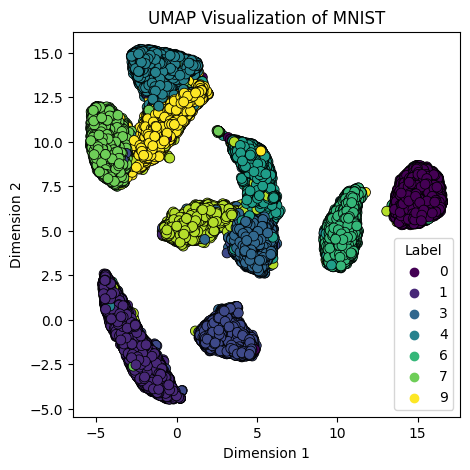

In [71]:
import seaborn as sns
import pandas as pd

# Creating a DataFrame for easy plotting with Seaborn
df = pd.DataFrame({'Dimension 1': embedding[:, 0], 'Dimension 2': embedding[:, 1], 'Label': y_train})

# Plotting with Seaborn
plt.figure(figsize=(5, 5))
sns.scatterplot(x='Dimension 1', y='Dimension 2', hue='Label', data=df, palette='viridis', edgecolor='k', s=50)

plt.title('UMAP Visualization of MNIST')
plt.show()